# Project in Keras

Based on: https://github.com/rachhek/speech_recognition_using_lstm/blob/master/speech_recognition_using_lstm_experiment.ipynb


In [1]:
! pip install python_speech_features

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for python_speech_features: filename=python_speech_features-0.6-py3-none-any.whl size=5879 sha256=d4671398ce46a9806edd386b73f90aa5846d9a18f9b3781d67c79cec2dfca4c0
  Stored in directory: c:\users\48695\appdata\local\pip\cache\wheels\37\01\19\e6c69a32684ab7b2e3ea4985a571d810cf055c72600e7f9f17
Successfully built python_speech_features


In [68]:
import os
import keras
#from keras import ops
from keras.layers import LSTM, Dense, Dropout, Embedding, Masking, Bidirectional,Flatten,Input
from keras.layers import SpatialDropout1D, SpatialDropout2D, SpatialDropout3D, Bidirectional
from keras.layers import Conv1D, BatchNormalization, Conv2D, MaxPooling2D, MaxPooling1D, Flatten, Dropout
from keras.layers import MultiHeadAttention, LayerNormalization, GlobalAveragePooling2D, Layer
#from python_speech_features import mfcc
#from python_speech_features import logfbank
from keras.models import Sequential, load_model
from keras.optimizers import Adam
from keras.utils import plot_model
import tensorflow as tf
from tensorflow import keras
#import tensorflow_models as tfm
#from tensorflow_models.nlp import layers
from official.nlp.modeling.models import TransformerEncoder, TransformerDecoder
#from keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences
from sklearn.preprocessing import LabelEncoder,normalize
from matplotlib import pyplot
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
import scipy.io.wavfile as wav
import numpy as np
import csv
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score,ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt
import time
#import librosa
#import soundfile as sf
import pickle 

metrics=['categorical_accuracy','AUC','Precision','Recall'] #można potem obliczyć F1 na podstawie recall i precision
metrics2 = ['categorical_accuracy','precision','recall']
train_path = "./train/audio/" 
val_text = "./train/validation_list.txt"
test_text = "./train/testing_list.txt"
root = "./train/"
preprocessed = "./preprocessed"

In [69]:
def show_confusion_matrix(model, test_ds, num_classes, class_names):
    true_labels = np.concatenate([y for x, y in test_ds], axis=0)
    tf_labels = tf.argmax(true_labels, axis=1).numpy()

    predictions = model.predict(test_ds)
    predicted_classes = np.argmax(predictions, axis=1)

    conf_matrix = tf.math.confusion_matrix(tf_labels, predicted_classes, num_classes=num_classes)

    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix.numpy(), display_labels=class_names)
    fig, ax = plt.subplots(figsize=(11, 9))  # Ustaw rozmiar wykresu na 10x8

    # Wyświetl macierz pomyłek z określonym rozmiarem
    disp.plot(ax=ax)  # Użyj parametru ax, aby użyć określonej osi
    plt.show()
    return

In [70]:
def show_training_validation_loss_and_metrics(model,metrics):
    f,ax=plt.subplots(2,1,figsize=(20,20)) 

    #Assigning the first subplot to graph training loss and validation loss
    ax[0].plot(model.history.history['loss'],color='b',label='Training Loss')
    ax[0].plot(model.history.history['val_loss'],color='r',label='Validation Loss')

    #Plotting the training accuracy and validation accuracy
    for metric in metrics:
        ax[1].plot(model.history.history[metric],label='Training '+metric)
        ax[1].plot(model.history.history['val_'+metric],label='Validation '+metric)
    
    plt.legend() 

# Preprocessing with spectogram (can be run only once)

In [7]:
def convert_background_noise(root_path='./train', input_folder='_background_noise_', output_folder='silence'):
    audio_path = os.path.join(root_path, 'audio')
    input_path = os.path.join(audio_path, input_folder)
    output_path = os.path.join(audio_path, output_folder)
    
    sample_rate = 16000
    sample_length = 1

    audio_files = [d for d in os.listdir(input_path)
                   if os.path.isfile(os.path.join(input_path, d)) and d.endswith('.wav')]
    samples = []

    for f in audio_files:
        path = os.path.join(input_path, f)
        s, _ = librosa.load(path, sr=sample_rate)
        samples.append(s)

    samples = np.hstack(samples)
    c = int(sample_rate * sample_length)
    r = len(samples) // c
    names = [f'recording_{i}.wav' for i in range(r-1)]

    if not os.path.exists(output_path):
        os.makedirs(output_path)

    for i in range(r - 1):
        y = samples[c*i:c*(i+1)]
        sf.write(os.path.join(output_path, names[i]), y, sample_rate)

    val_choice = np.random.choice(names, int(0.1*len(names)), replace=False).tolist()
    with open(os.path.join(root_path, 'validation_list.txt'), 'a') as f:
        for name in val_choice:
            p = os.path.join(output_folder, name)
            p = p.replace('./', '')
            f.write(p)
            f.write('\n')

    test_choice = np.random.choice([n for n in names if n not in val_choice], int(0.1*len(names)), replace=False).tolist()
    with open(os.path.join(root_path, 'testing_list.txt'), 'a') as f:
        for name in test_choice:
            p = os.path.join(output_folder, name)
            p = p.replace('./', '')
            f.write(p)
            f.write('\n')


In [8]:
convert_background_noise(root_path=root, input_folder='_background_noise_', output_folder='silence')

In [9]:
def load_dataset(root_path_files, files_names_list_name, label_encoder=None):
    #Calculating x_test and y_test        
    test_labels = []
    test_data = []

    #test_labels.txt is a txt file with all labels for the speech samples that is required for the evaluation. We loop through it to calculate the MFCC value for each speech sample and then normalize it
    with open(os.path.join(root_path_files, files_names_list_name), newline='') as tsvfile:
        reader = csv.DictReader(tsvfile)
        reader = csv.reader(tsvfile, delimiter=' ')
        for row in reader:
            wav_file = os.path.join(root_path_files, "audio/", row[0])

            row.append(row[0].split("/")[0])
            (rate,sig) = wav.read(wav_file)

            # pad to 1s of length using pad_sequences
            sig = pad_sequences([sig], maxlen=16000, dtype='float', padding='post', truncating='post', value=0.0)

            #Getting the MFCC value from the .wav files.
            mfcc_feat = mfcc(sig,rate)
            
            scaler = MinMaxScaler(feature_range=(0,1))
            scaler = scaler.fit(mfcc_feat)

            #Normalizing the MFCC values.
            normalized = scaler.transform(mfcc_feat)
            test_data.append(normalized)
            test_labels.append(str(row[1]))
        
        if label_encoder is None:
            label_encoder_test = LabelEncoder().fit(test_labels)
        else:
            label_encoder_test = label_encoder
        vec_test = label_encoder_test.transform(test_labels)

        #One hot encoding the labels
        one_hot_labels_test = keras.utils.to_categorical(vec_test, num_classes=len(label_encoder_test.classes_))
        Y_test = one_hot_labels_test
        X_test = np.array(test_data,dtype=np.float32)
        return X_test, Y_test, label_encoder_test

In [10]:
def generate_train_txt(root_path_files, files_names_list_name):
    omit = []
    train = []
    for f in files_names_list_name:
        with open(os.path.join(root_path_files, f)) as fileobj:
            omit += [line.strip() for line in fileobj]
    for target in os.listdir(os.path.join(root_path_files, 'audio')):
        if not target.startswith('_'):
            for file in os.listdir(os.path.join(root_path_files, 'audio', target)):
                p = os.path.join(target, file)
                p = p.replace("\\","/")
                if p not in omit:
                    train.append(p)
    with open(os.path.join(root_path_files, 'training_list.txt'), 'wb') as file:
        for t in train:
            file.write(t.encode())
            file.write('\n'.encode())

In [11]:
root_path_files = root
root_saved_files = preprocessed
generate_train_txt(root_path_files, ['validation_list.txt', 'testing_list.txt'])
classes = os.listdir(root_path_files+"/audio")
print(classes)

['bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'four', 'go', 'happy', 'house', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'silence', 'six', 'stop', 'three', 'tree', 'two', 'up', 'wow', 'yes', 'zero', '_background_noise_']


In [13]:
root_path_files = root
root_saved_files = preprocessed

generate_train_txt(root_path_files, ['validation_list.txt', 'testing_list.txt'])

train_files_names_list_name = 'training_list.txt'
X_train, Y_train, label_encoder = load_dataset(root_path_files=root_path_files, files_names_list_name=train_files_names_list_name)
np.save(os.path.join(root_saved_files, 'X_train'), X_train)
np.save(os.path.join(root_saved_files, 'Y_train'), Y_train)

valid_files_names_list_name = 'validation_list.txt'
X_valid, Y_valid, _ = load_dataset(root_path_files=root_path_files, files_names_list_name=valid_files_names_list_name, 
                                   label_encoder=label_encoder)
np.save(os.path.join(root_saved_files, 'X_valid'), X_valid)
np.save(os.path.join(root_saved_files, 'Y_valid'), Y_valid)

test_files_names_list_name = 'testing_list.txt'
X_test, Y_test, _ = load_dataset(root_path_files=root_path_files, files_names_list_name=test_files_names_list_name, 
                                 label_encoder=label_encoder)
np.save(os.path.join(root_saved_files, 'X_test'), X_test)
np.save(os.path.join(root_saved_files, 'Y_test'), Y_test)

In [14]:
with open('encoder', 'wb') as f:
    pickle.dump(label_encoder, f)

In [15]:
print(label_encoder.classes_)

['bed' 'bird' 'cat' 'dog' 'down' 'eight' 'five' 'four' 'go' 'happy'
 'house' 'left' 'marvin' 'nine' 'no' 'off' 'on' 'one' 'right' 'seven'
 'sheila' 'silence' 'six' 'stop' 'three' 'tree' 'two' 'up' 'wow' 'yes'
 'zero']


# Loading data

In [ ]:
#! pip install gdown
#! gdown https://drive.google.com/uc?id=1S0ZWGTnKzyaYfLUOzii_LFnrqdygLDtf
#! mkdir ./preprocessed
#! unzip preprocessed.zip -d ./preprocessed
#! mv ./preprocessed/encoder ./

In [71]:
# load the test data and labels
root_saved_files = preprocessed

X_train = np.load(os.path.join(root_saved_files,'X_train.npy'))
Y_train = np.load(os.path.join(root_saved_files, 'Y_train.npy'))

X_test = np.load(os.path.join(root_saved_files, 'X_test.npy'))
Y_test = np.load(os.path.join(root_saved_files, 'Y_test.npy'))

X_valid = np.load(os.path.join(root_saved_files, 'X_valid.npy'))
Y_valid = np.load(os.path.join(root_saved_files, 'Y_valid.npy'))

In [72]:
with open('encoder', 'rb') as f:
    encoder = pickle.load(f)
    CLASSES = encoder.classes_

In [73]:
print(CLASSES)

['bed' 'bird' 'cat' 'dog' 'down' 'eight' 'five' 'four' 'go' 'happy'
 'house' 'left' 'marvin' 'nine' 'no' 'off' 'on' 'one' 'right' 'seven'
 'sheila' 'silence' 'six' 'stop' 'three' 'tree' 'two' 'up' 'wow' 'yes'
 'zero']


# Experiments

In [74]:
n_classes = len(CLASSES)

In [75]:
def update_seed(new_random_seed):
    np.random.seed(new_random_seed)
    tf.keras.utils.set_random_seed(new_random_seed)

In [76]:
def train_model(model, train_data, val_data, test_data, lr, epochs, batch, path='checkpoint'):
    callbacks = [
        EarlyStopping(monitor='val_loss', min_delta=0.01, patience=3, mode = 'min')
    ]
    m = model()
    m.compile(optimizer=Adam(amsgrad=True, learning_rate=lr),loss='categorical_crossentropy',metrics=metrics)
    history = m.fit(train_data[0], train_data[1],
                    epochs=epochs,
                    callbacks=callbacks,
                    batch_size=batch,
                    validation_data=val_data,
                    verbose=1,
                    shuffle=True)

    datetime = time.strftime("%Y%m%d-%H%M%S")
    m.save(os.path.join(path, 'model_' + datetime + '.keras'))

    show_training_validation_loss_and_metrics(m, metrics2)

    y_prediction = m.predict(test_data[0])
    y_prediction = np.argmax(y_prediction, axis = 1)
    y_test_single_column=np.argmax(test_data[1], axis=1)
    result = confusion_matrix(y_test_single_column, y_prediction , normalize='pred')
    plt.figure(figsize=(20,20))
    labels = CLASSES
    sns.heatmap(result, annot=True, fmt='.2f', xticklabels=labels, yticklabels=labels)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Confusion matrix on test data')
    plt.show()
    
    result = confusion_matrix(y_test_single_column, y_prediction)
    plt.figure(figsize=(20,20))
    labels = CLASSES
    sns.heatmap(result, annot=True, fmt='.2f', xticklabels=labels, yticklabels=labels)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Confusion matrix on test data')
    plt.show()
    
    acc_train = accuracy_score(np.argmax(train_data[1], axis=1), np.argmax(m.predict(train_data[0]), axis = 1))
    print(f"Accuracy score on train dataset: {acc_train}")
    acc_val = accuracy_score(np.argmax(val_data[1], axis=1), np.argmax(m.predict(val_data[0]), axis = 1))
    print(f"Accuracy score on validation dataset: {acc_val}")
    acc_test = accuracy_score(y_test_single_column, y_prediction)
    print(f"Accuracy score on test dataset: {acc_test}")

    return [acc_train, acc_val, acc_test]

In [77]:
def repeat_train(model, train_data, val_data, test_data, lr, epochs, batch, seeds, path='checkpoint'):
    accuracy = []
    for seed in seeds:
        print(f"Training with seed {seed}")
        p = os.path.join(path, str(seed))
        if not os.path.exists(path):
            os.mkdir(path)
        if not os.path.exists(p):
            os.mkdir(p)
        update_seed(seed)
        acc = train_model(model, train_data, val_data, test_data, lr, epochs, batch, path=p)
        accuracy.append(acc)
    with open(os.path.join(path, 'accuracy'), 'wb') as f:
        pickle.dump(accuracy, f)

## Experiments running!

In [23]:
def modelLSTM():
    model = Sequential()
    model.add(LSTM(200,input_shape=(99,13),return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(Y_test.shape[1], activation='softmax'))
    return model

In [78]:
def modelTransformer():
    inputs = Input(shape=(99,13,))
    x_encoded = TransformerEncoder(num_attention_heads=13, num_layers=2, intermediate_size=128, dropout_rate=0.2, norm_first=True)(inputs)
    x_decoded = TransformerDecoder(num_attention_heads=13, num_layers=2, intermediate_size=128, dropout_rate=0.2, norm_first=True)(inputs, x_encoded)
    flatten = Flatten()(x_decoded)
    dropout = Dropout(0.2)(flatten)
    outputs = Dense(Y_test.shape[1], activation='softmax')(dropout)
    model = tf.keras.Model(inputs, outputs)
    return model

Training with seed 1234
Epoch 1/10
805/805 [==============================] - 396s 486ms/step - loss: 2.2241 - categorical_accuracy: 0.3628 - auc: 0.8834 - precision: 0.6960 - recall: 0.1941 - val_loss: 1.5105 - val_categorical_accuracy: 0.5469 - val_auc: 0.9487 - val_precision: 0.7323 - val_recall: 0.3806
Epoch 2/10
805/805 [==============================] - 396s 492ms/step - loss: 1.2946 - categorical_accuracy: 0.6191 - auc: 0.9600 - precision: 0.7972 - recall: 0.4757 - val_loss: 1.1489 - val_categorical_accuracy: 0.6656 - val_auc: 0.9660 - val_precision: 0.8101 - val_recall: 0.5592
Epoch 3/10
805/805 [==============================] - 395s 490ms/step - loss: 1.0284 - categorical_accuracy: 0.7000 - auc: 0.9719 - precision: 0.8357 - recall: 0.5957 - val_loss: 0.9984 - val_categorical_accuracy: 0.7126 - val_auc: 0.9713 - val_precision: 0.8255 - val_recall: 0.6352
Epoch 4/10
805/805 [==============================] - 392s 486ms/step - loss: 0.8920 - categorical_accuracy: 0.7426 - auc: 0

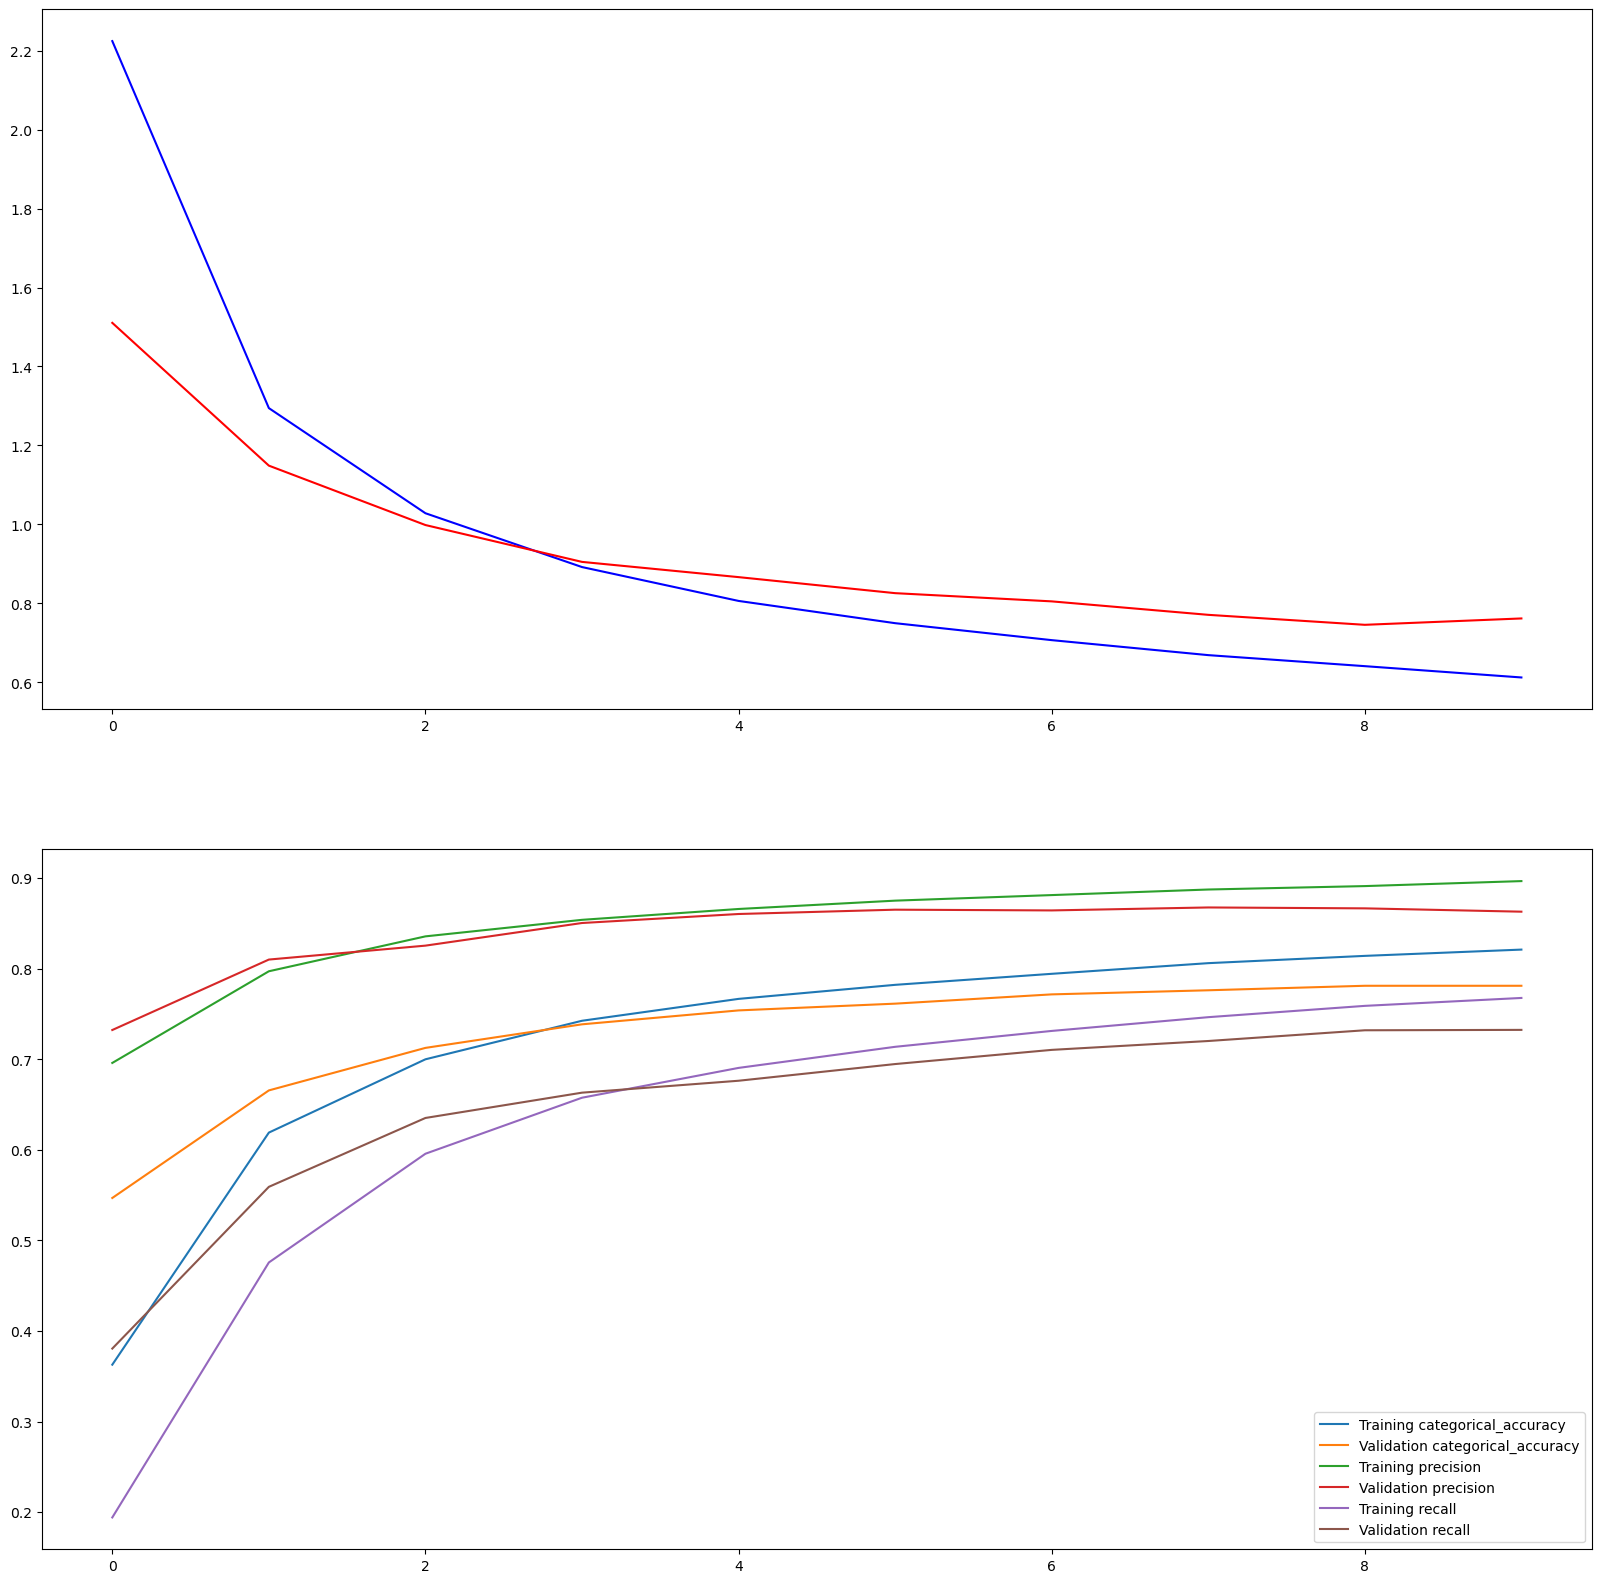

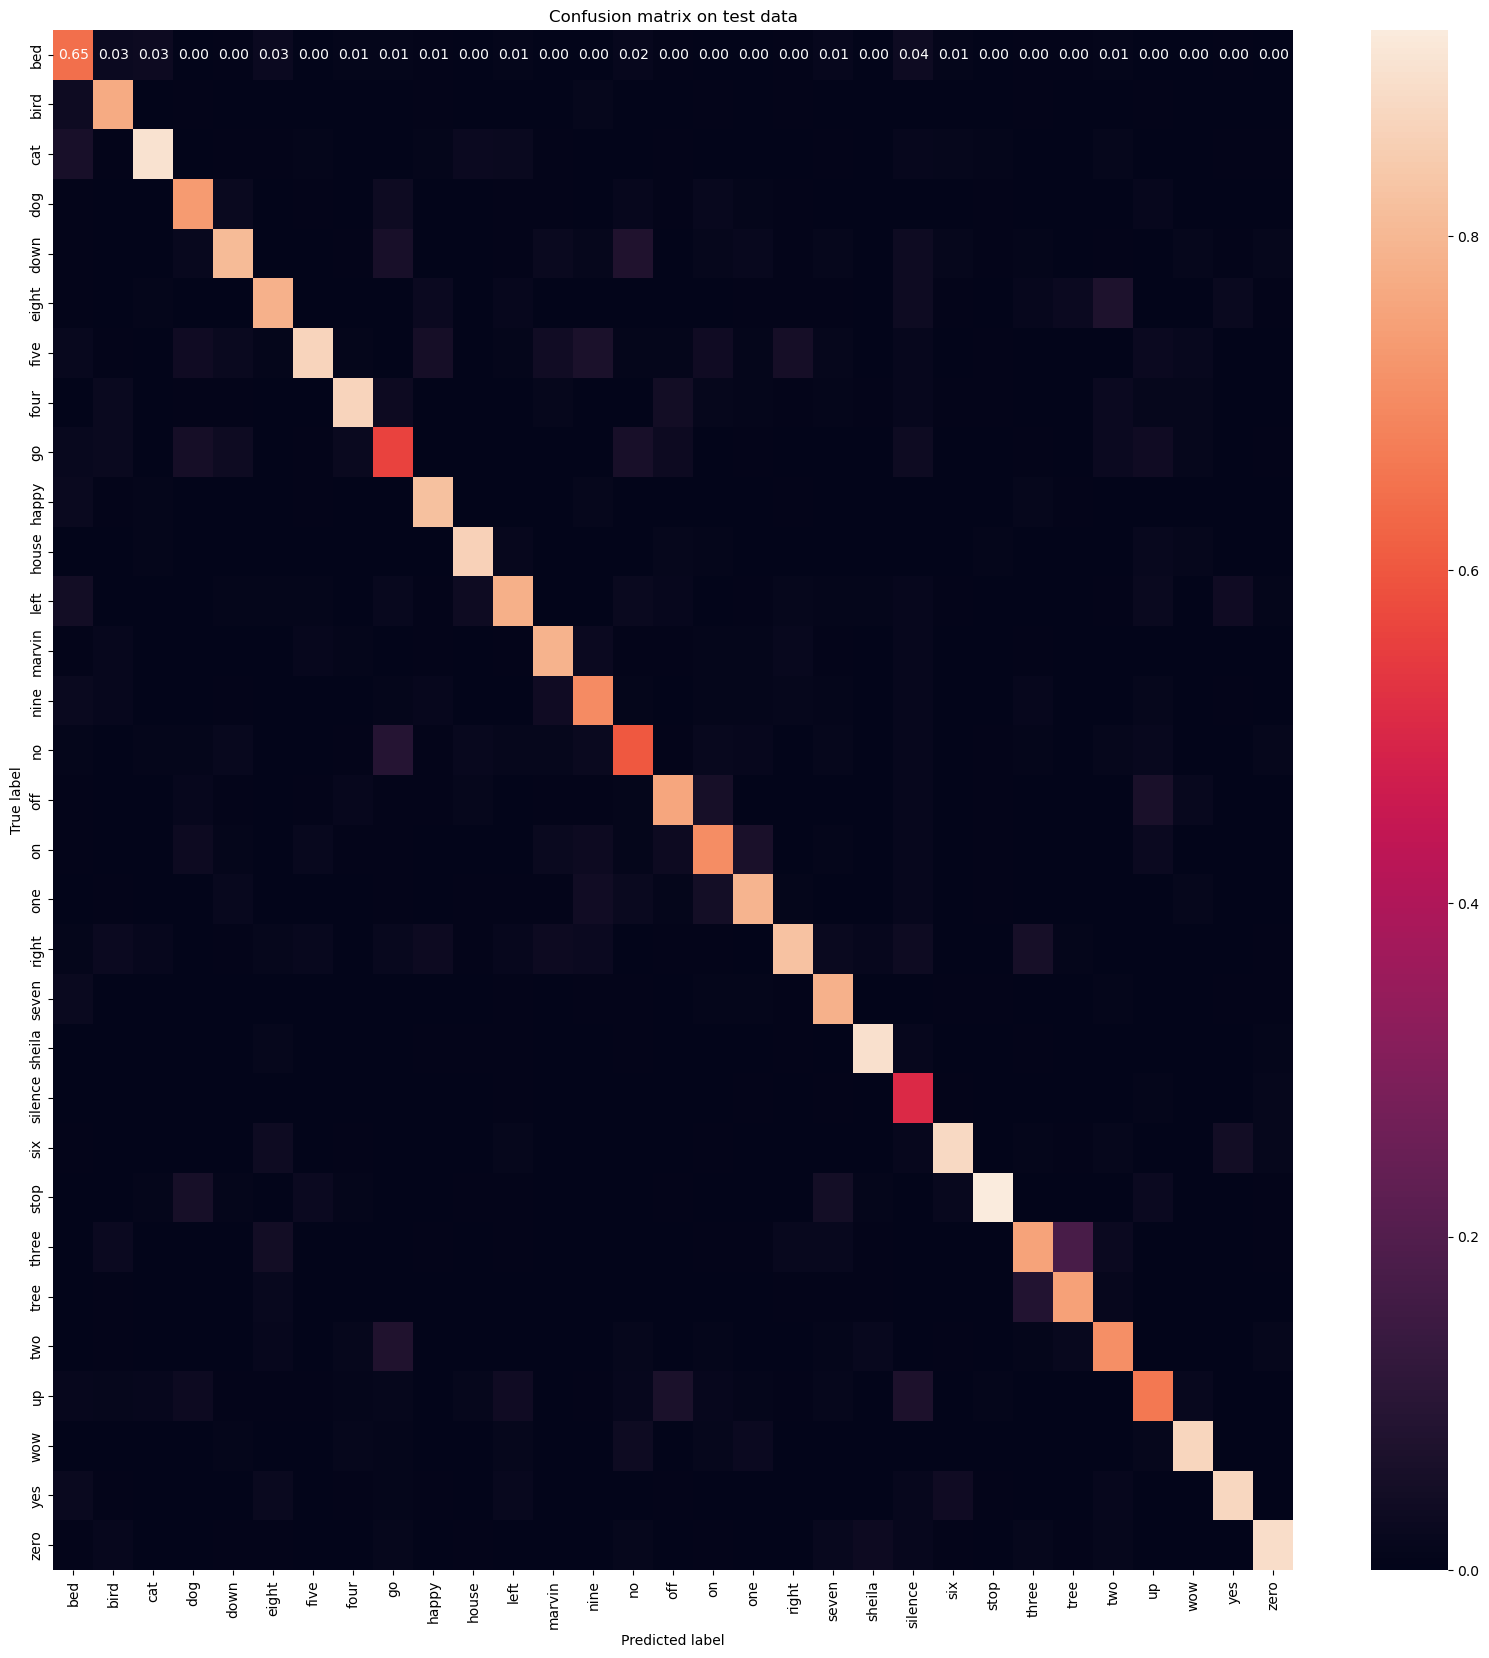

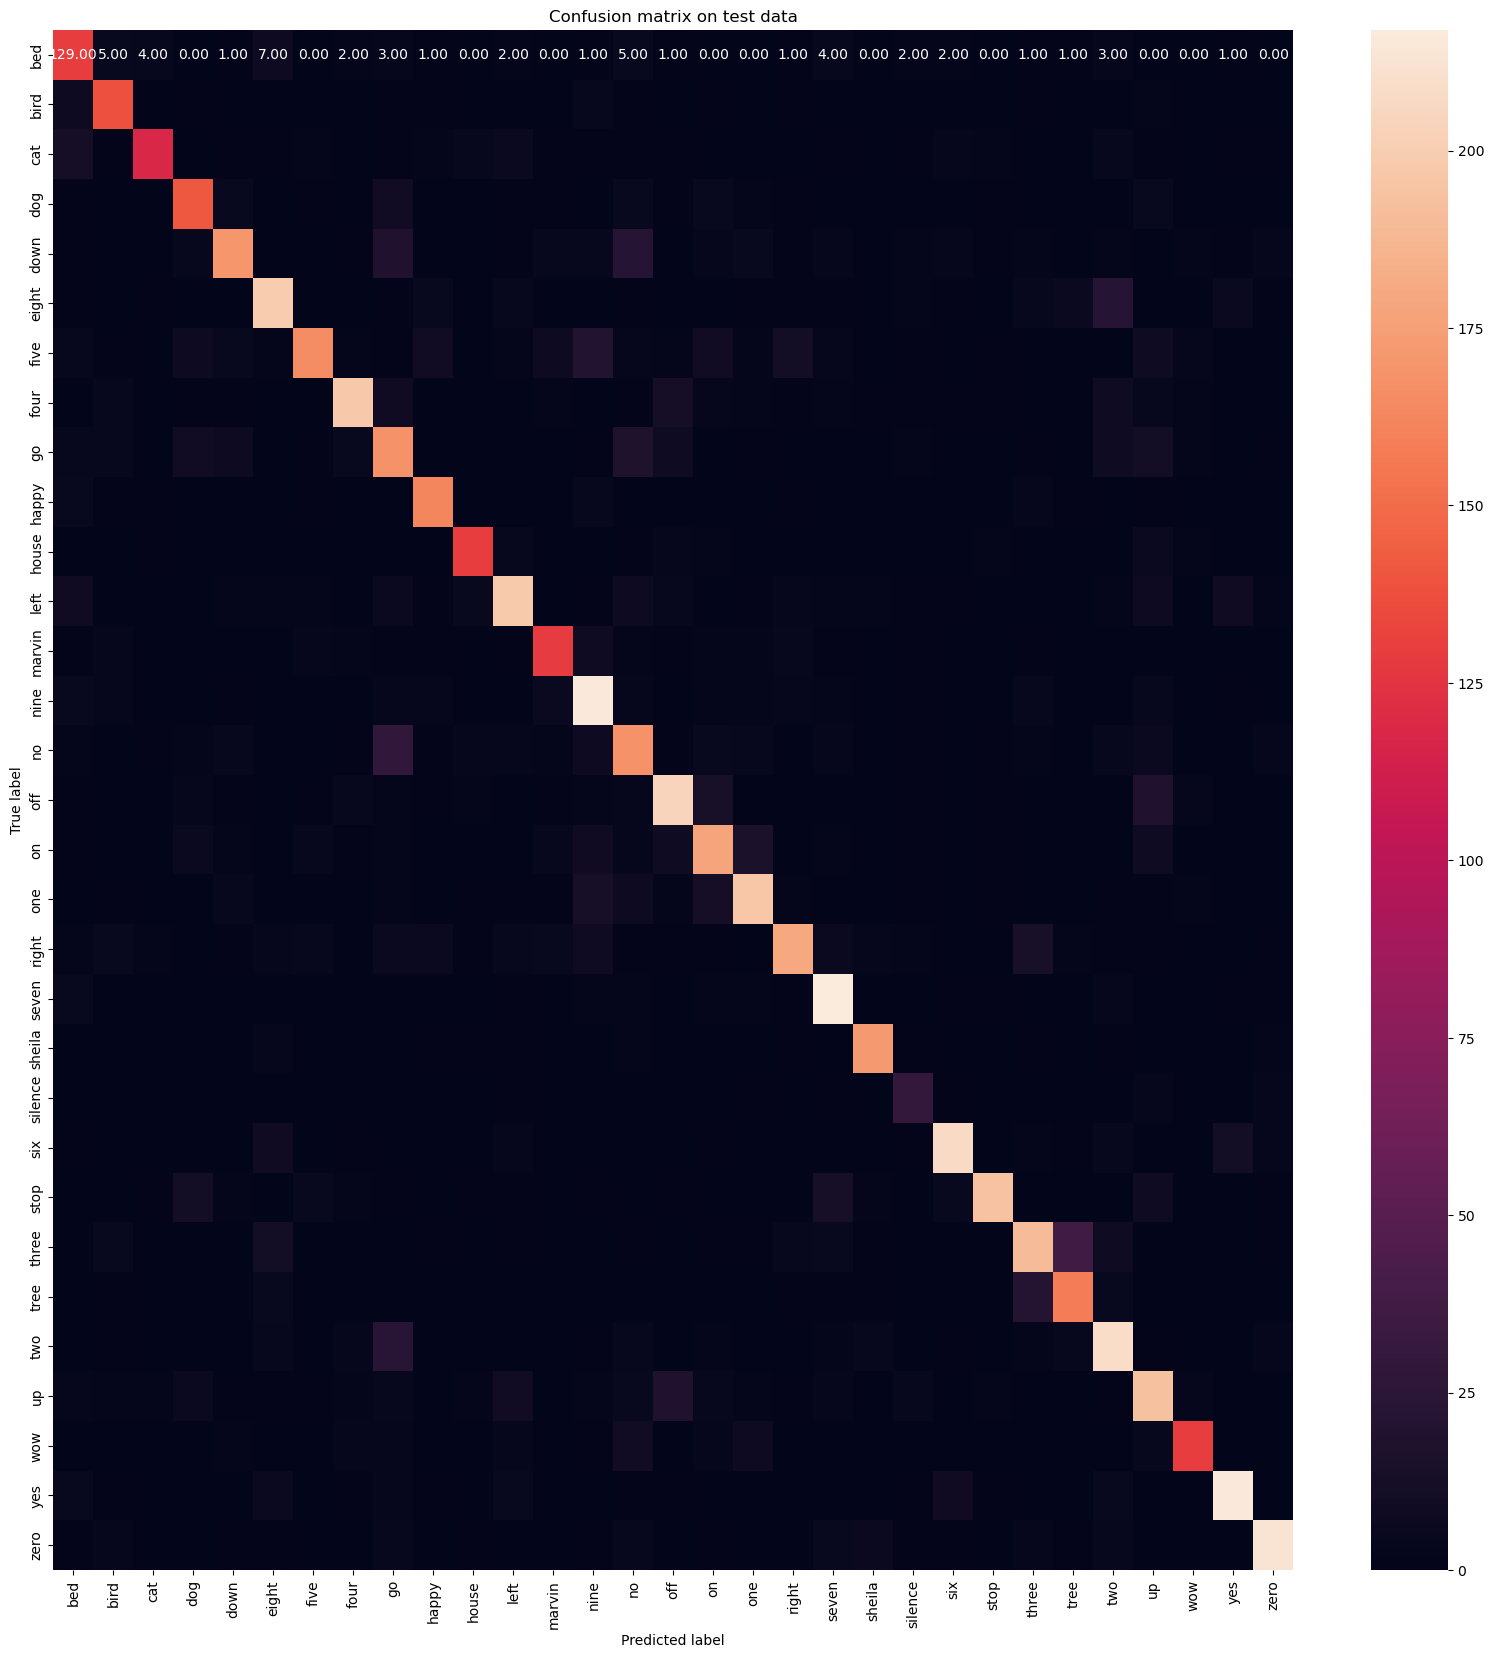

1609/1609 [==============================] - 197s 123ms/step
Accuracy score on train dataset: 0.8474342539719535
214/214 [==============================] - 26s 124ms/step
Accuracy score on validation dataset: 0.7811905806640339
Accuracy score on test dataset: 0.7724759965085831
Training with seed 7654
Epoch 1/10
805/805 [==============================] - 403s 496ms/step - loss: 2.1909 - categorical_accuracy: 0.3660 - auc: 0.8882 - precision: 0.6822 - recall: 0.1930 - val_loss: 1.4607 - val_categorical_accuracy: 0.5681 - val_auc: 0.9523 - val_precision: 0.7895 - val_recall: 0.3680
Epoch 2/10
805/805 [==============================] - 398s 494ms/step - loss: 1.2398 - categorical_accuracy: 0.6323 - auc: 0.9631 - precision: 0.7929 - recall: 0.5003 - val_loss: 1.0745 - val_categorical_accuracy: 0.6857 - val_auc: 0.9701 - val_precision: 0.8199 - val_recall: 0.5761
Epoch 3/10
805/805 [==============================] - 404s 502ms/step - loss: 0.9640 - categorical_accuracy: 0.7173 - auc: 0.9752

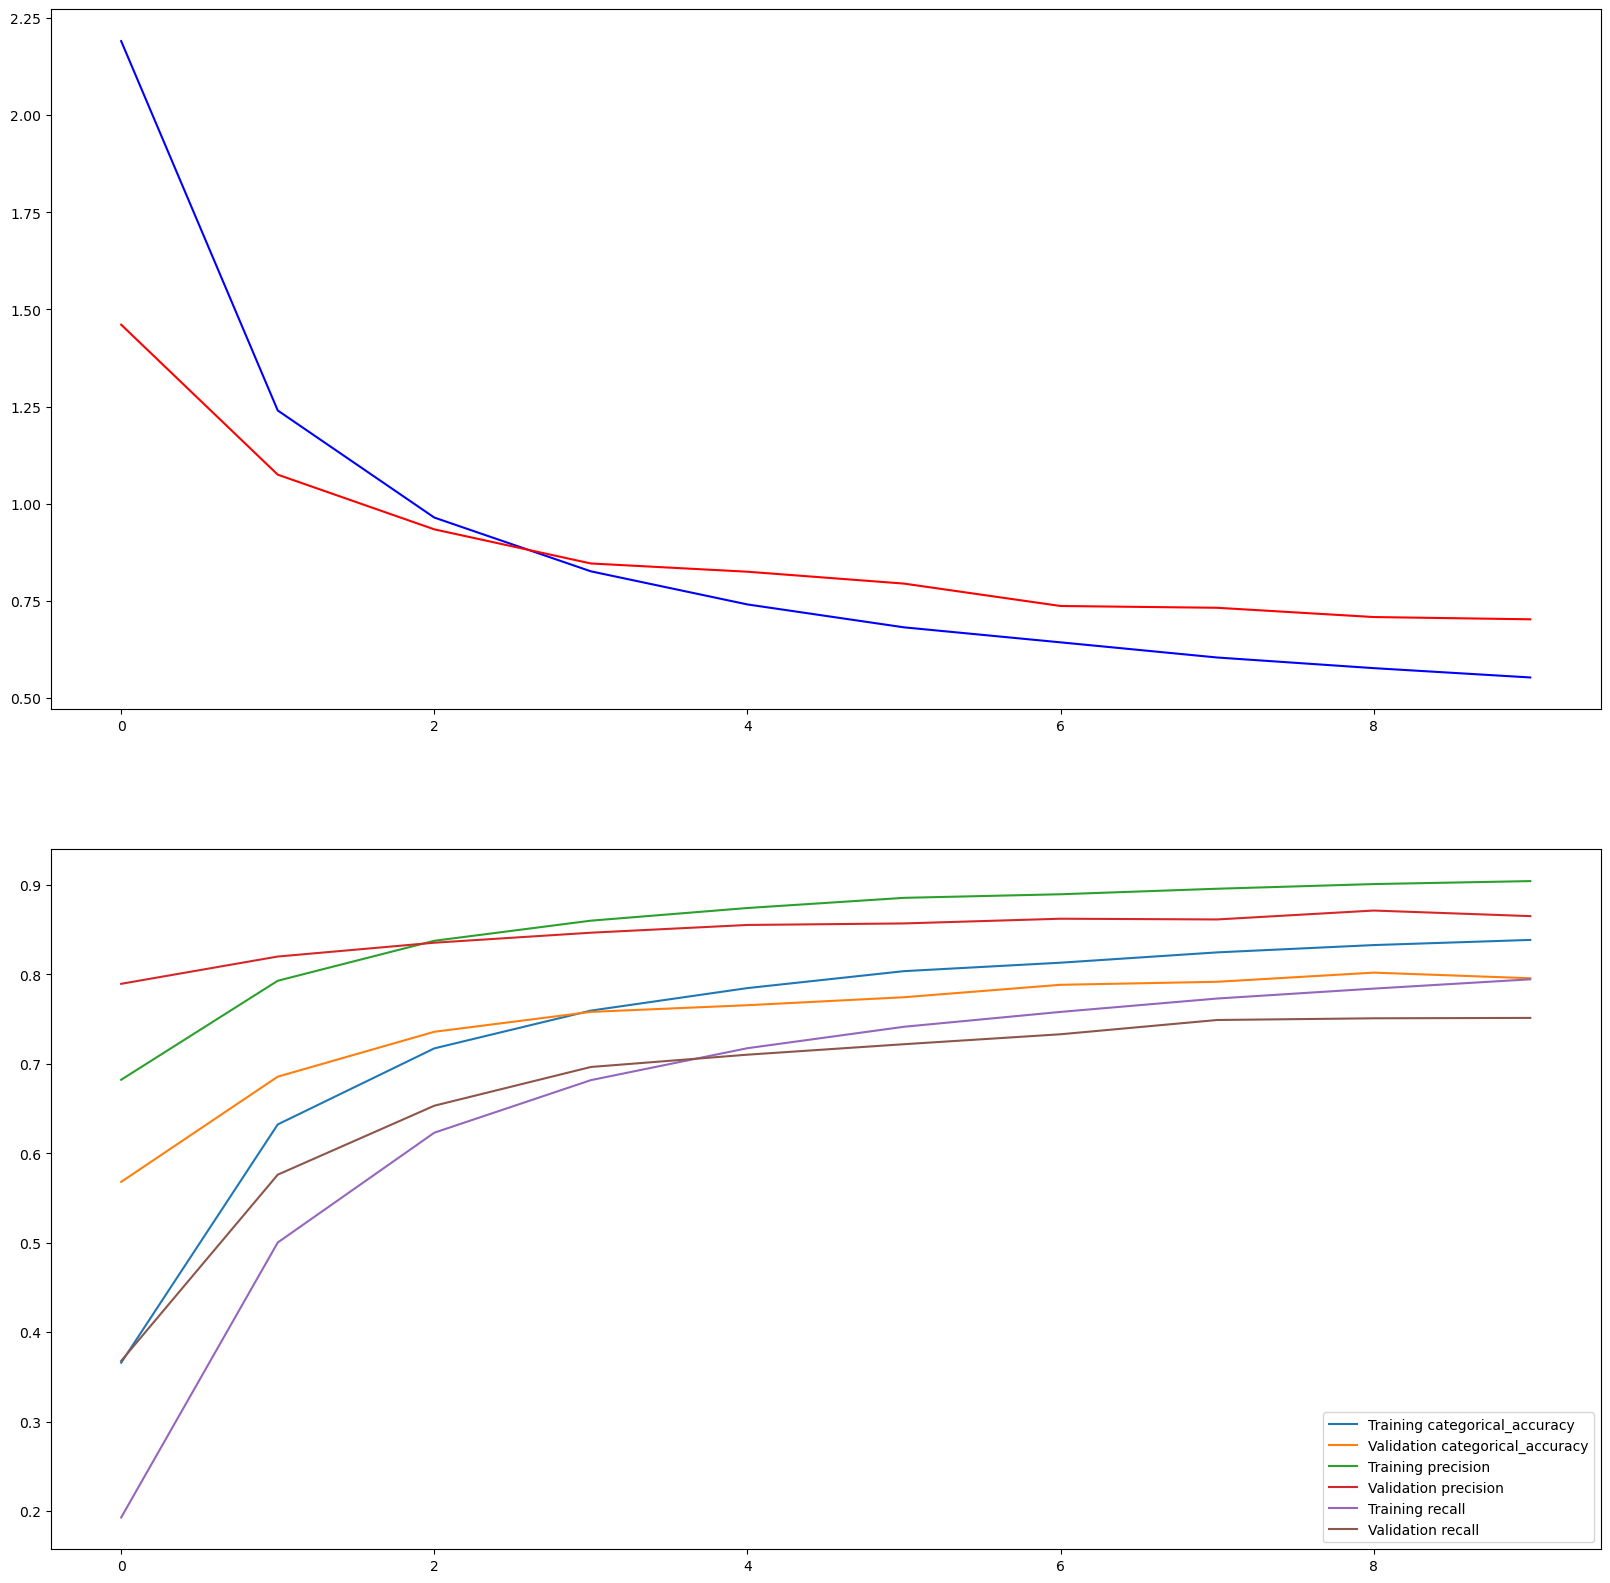

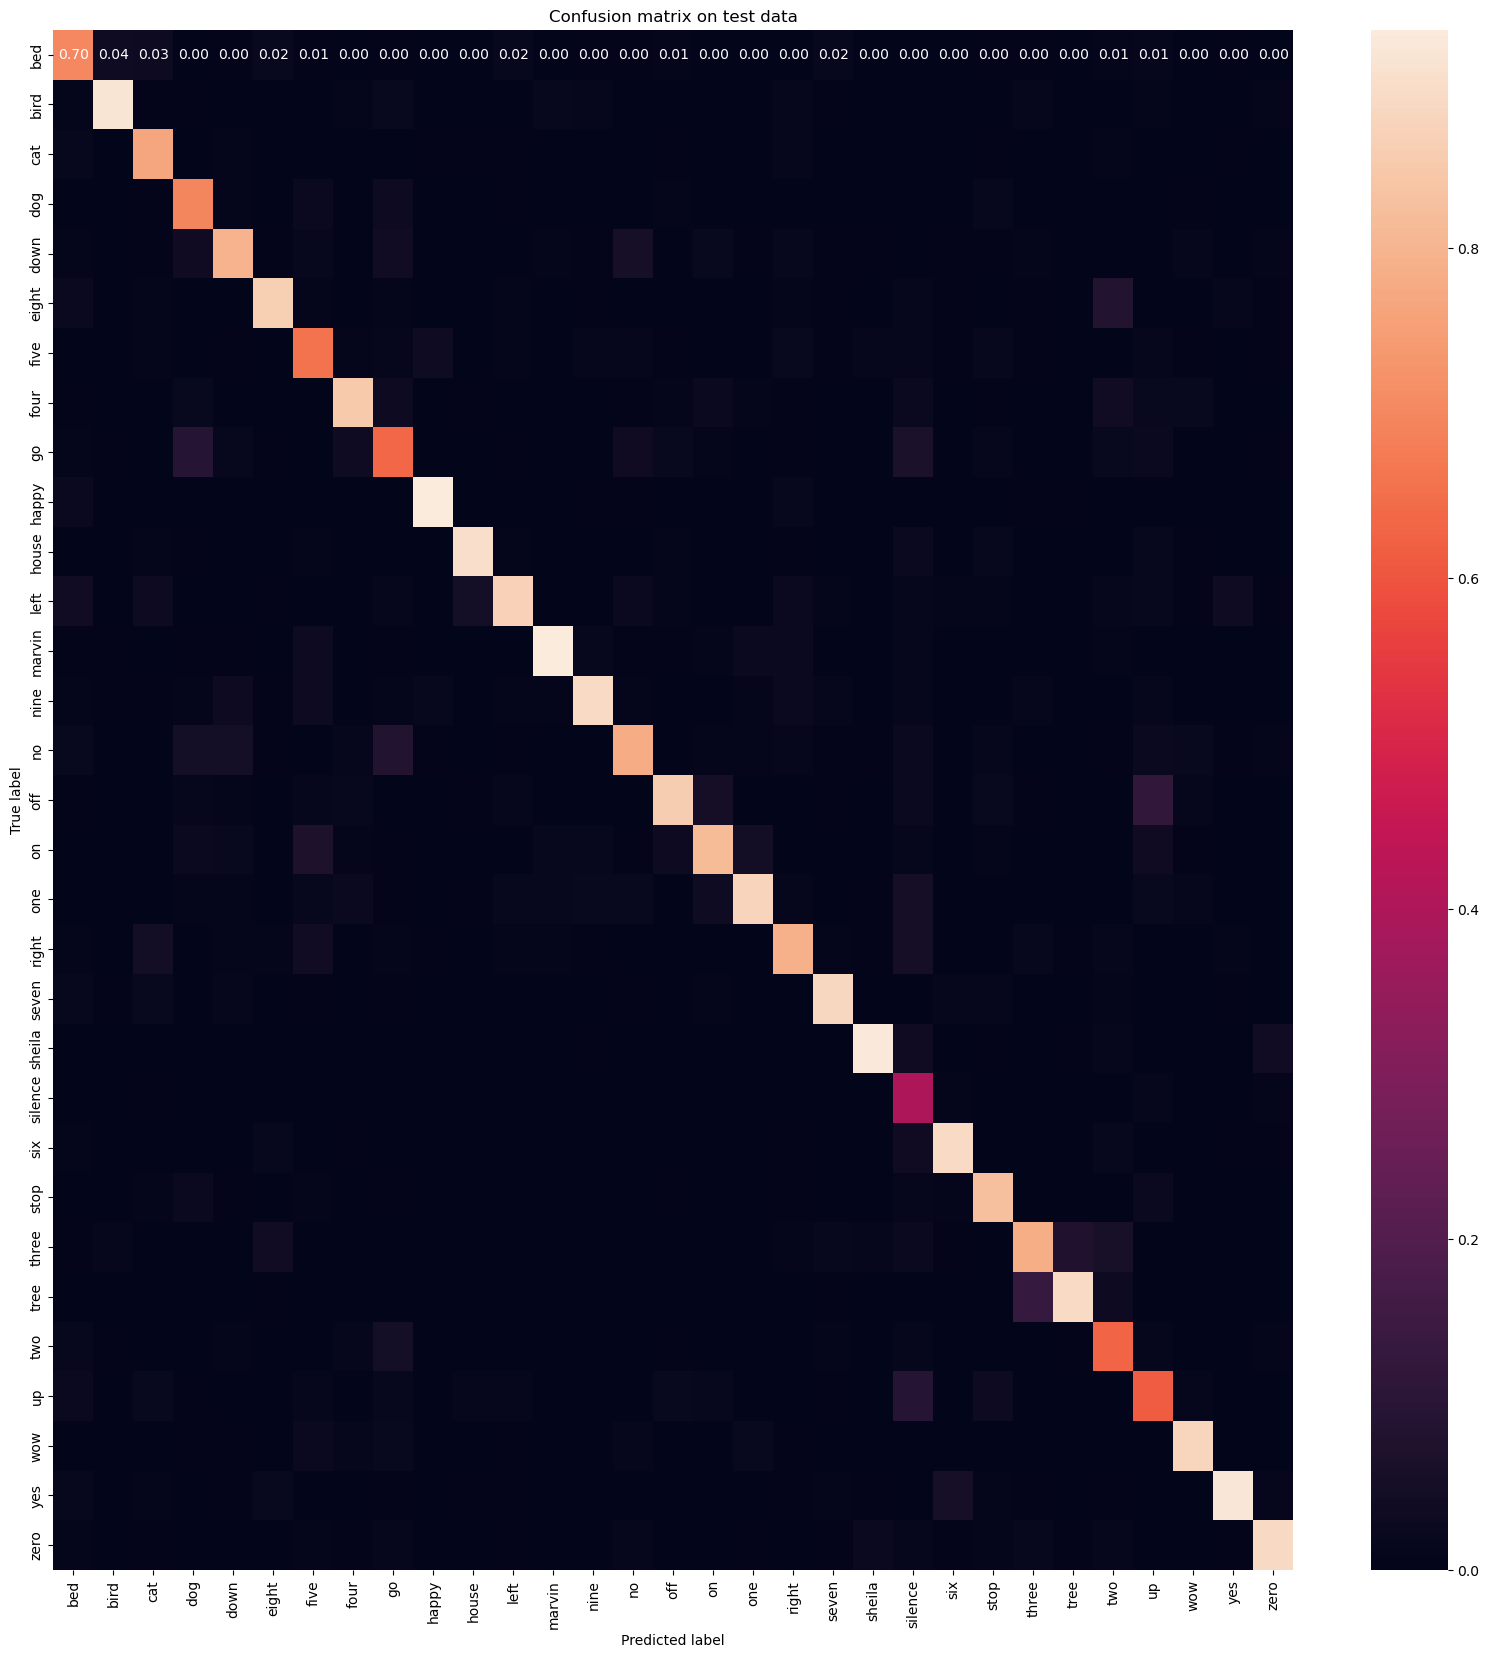

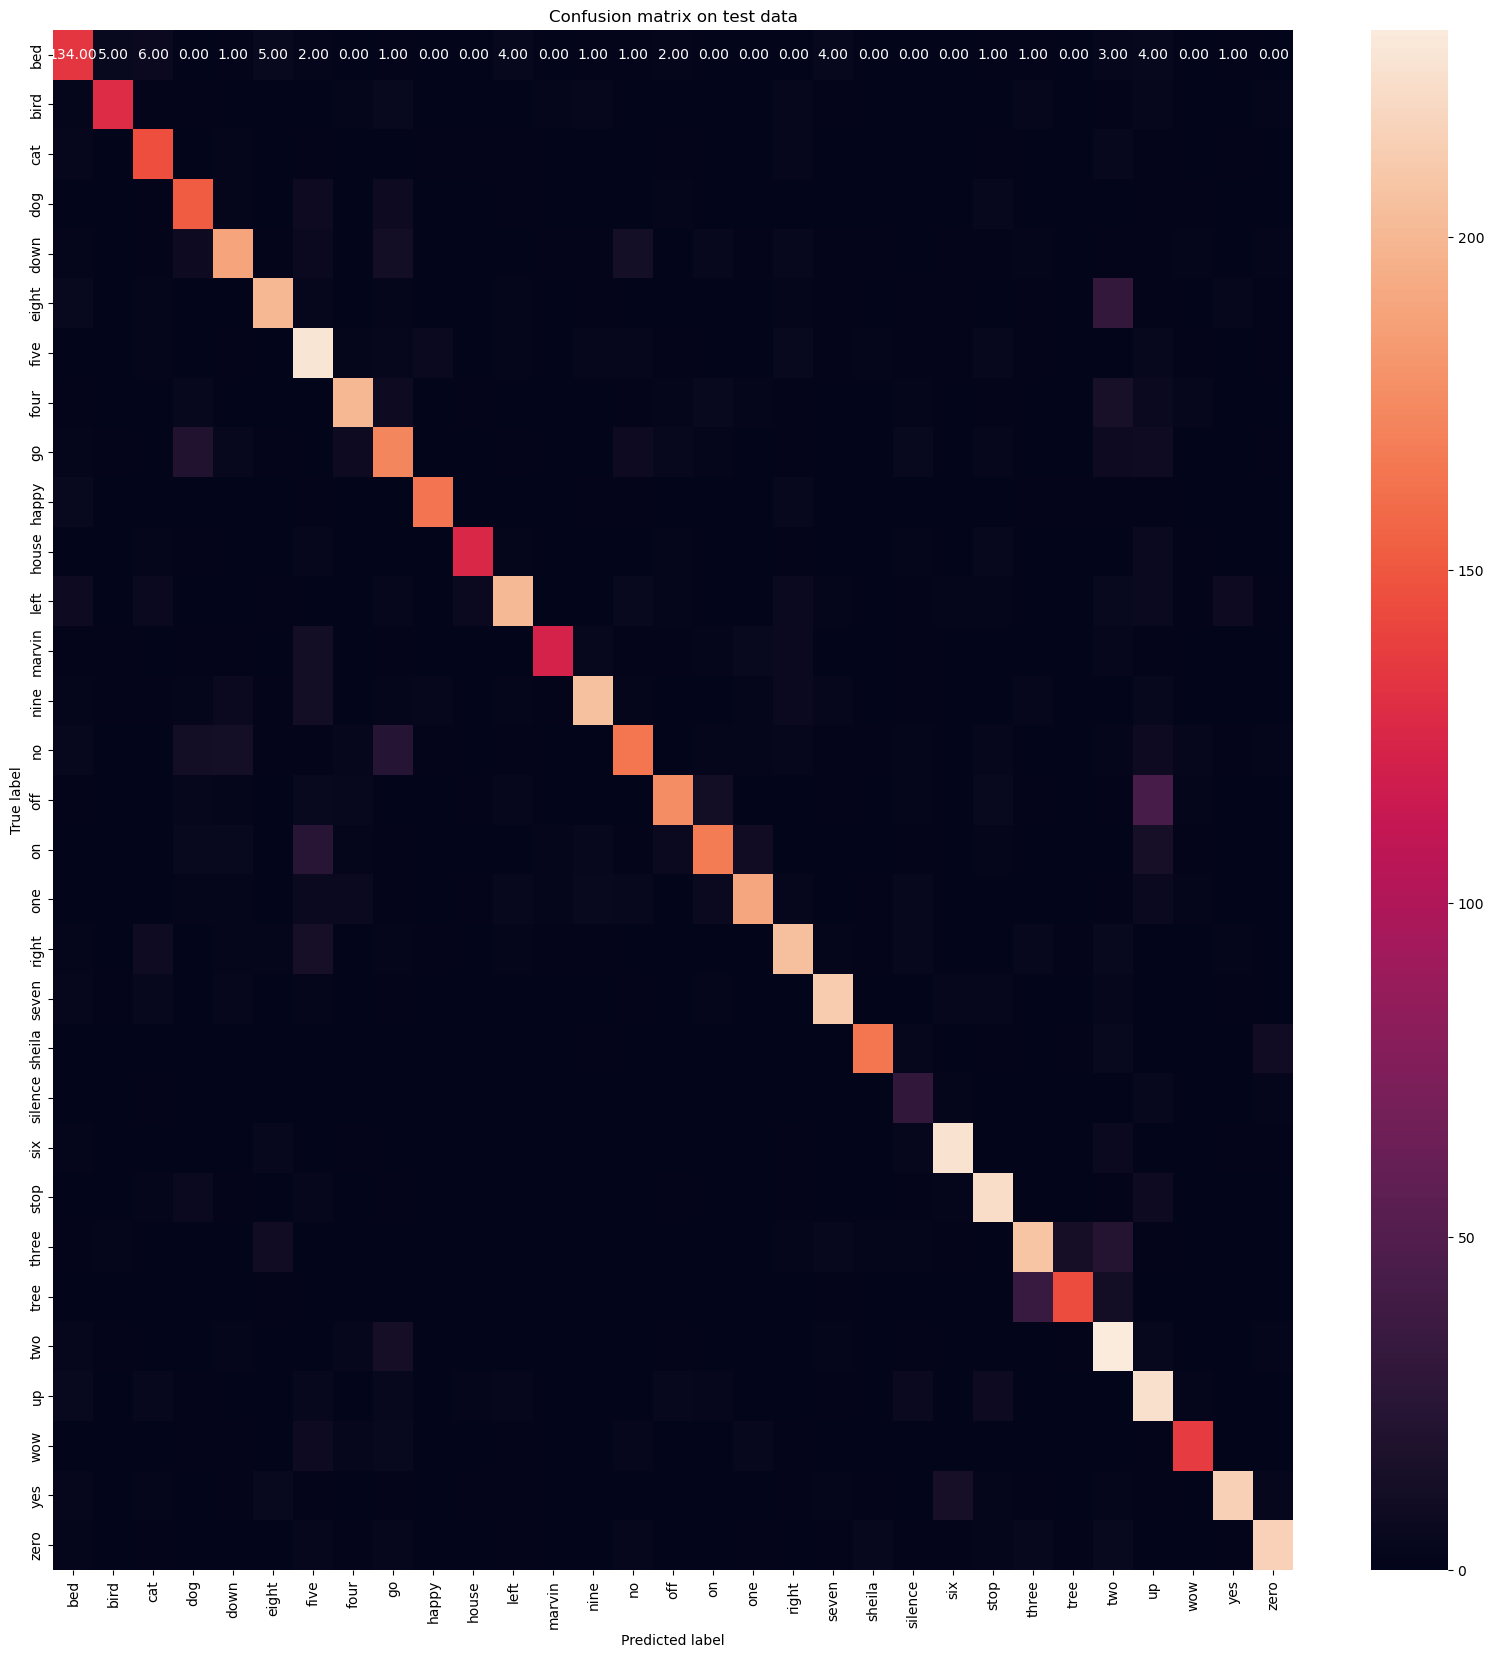

1609/1609 [==============================] - 198s 123ms/step
Accuracy score on train dataset: 0.8614186380763703
214/214 [==============================] - 26s 121ms/step
Accuracy score on validation dataset: 0.7956706157671494
Accuracy score on test dataset: 0.7996799534477742
Training with seed 313
Epoch 1/10
805/805 [==============================] - 409s 503ms/step - loss: 2.2585 - categorical_accuracy: 0.3483 - auc: 0.8808 - precision: 0.6797 - recall: 0.1776 - val_loss: 1.4790 - val_categorical_accuracy: 0.5577 - val_auc: 0.9512 - val_precision: 0.7572 - val_recall: 0.3923
Epoch 2/10
805/805 [==============================] - 406s 504ms/step - loss: 1.2432 - categorical_accuracy: 0.6319 - auc: 0.9628 - precision: 0.7929 - recall: 0.5025 - val_loss: 1.0642 - val_categorical_accuracy: 0.6854 - val_auc: 0.9707 - val_precision: 0.8243 - val_recall: 0.5744
Epoch 3/10
805/805 [==============================] - 405s 503ms/step - loss: 0.9770 - categorical_accuracy: 0.7137 - auc: 0.9745 

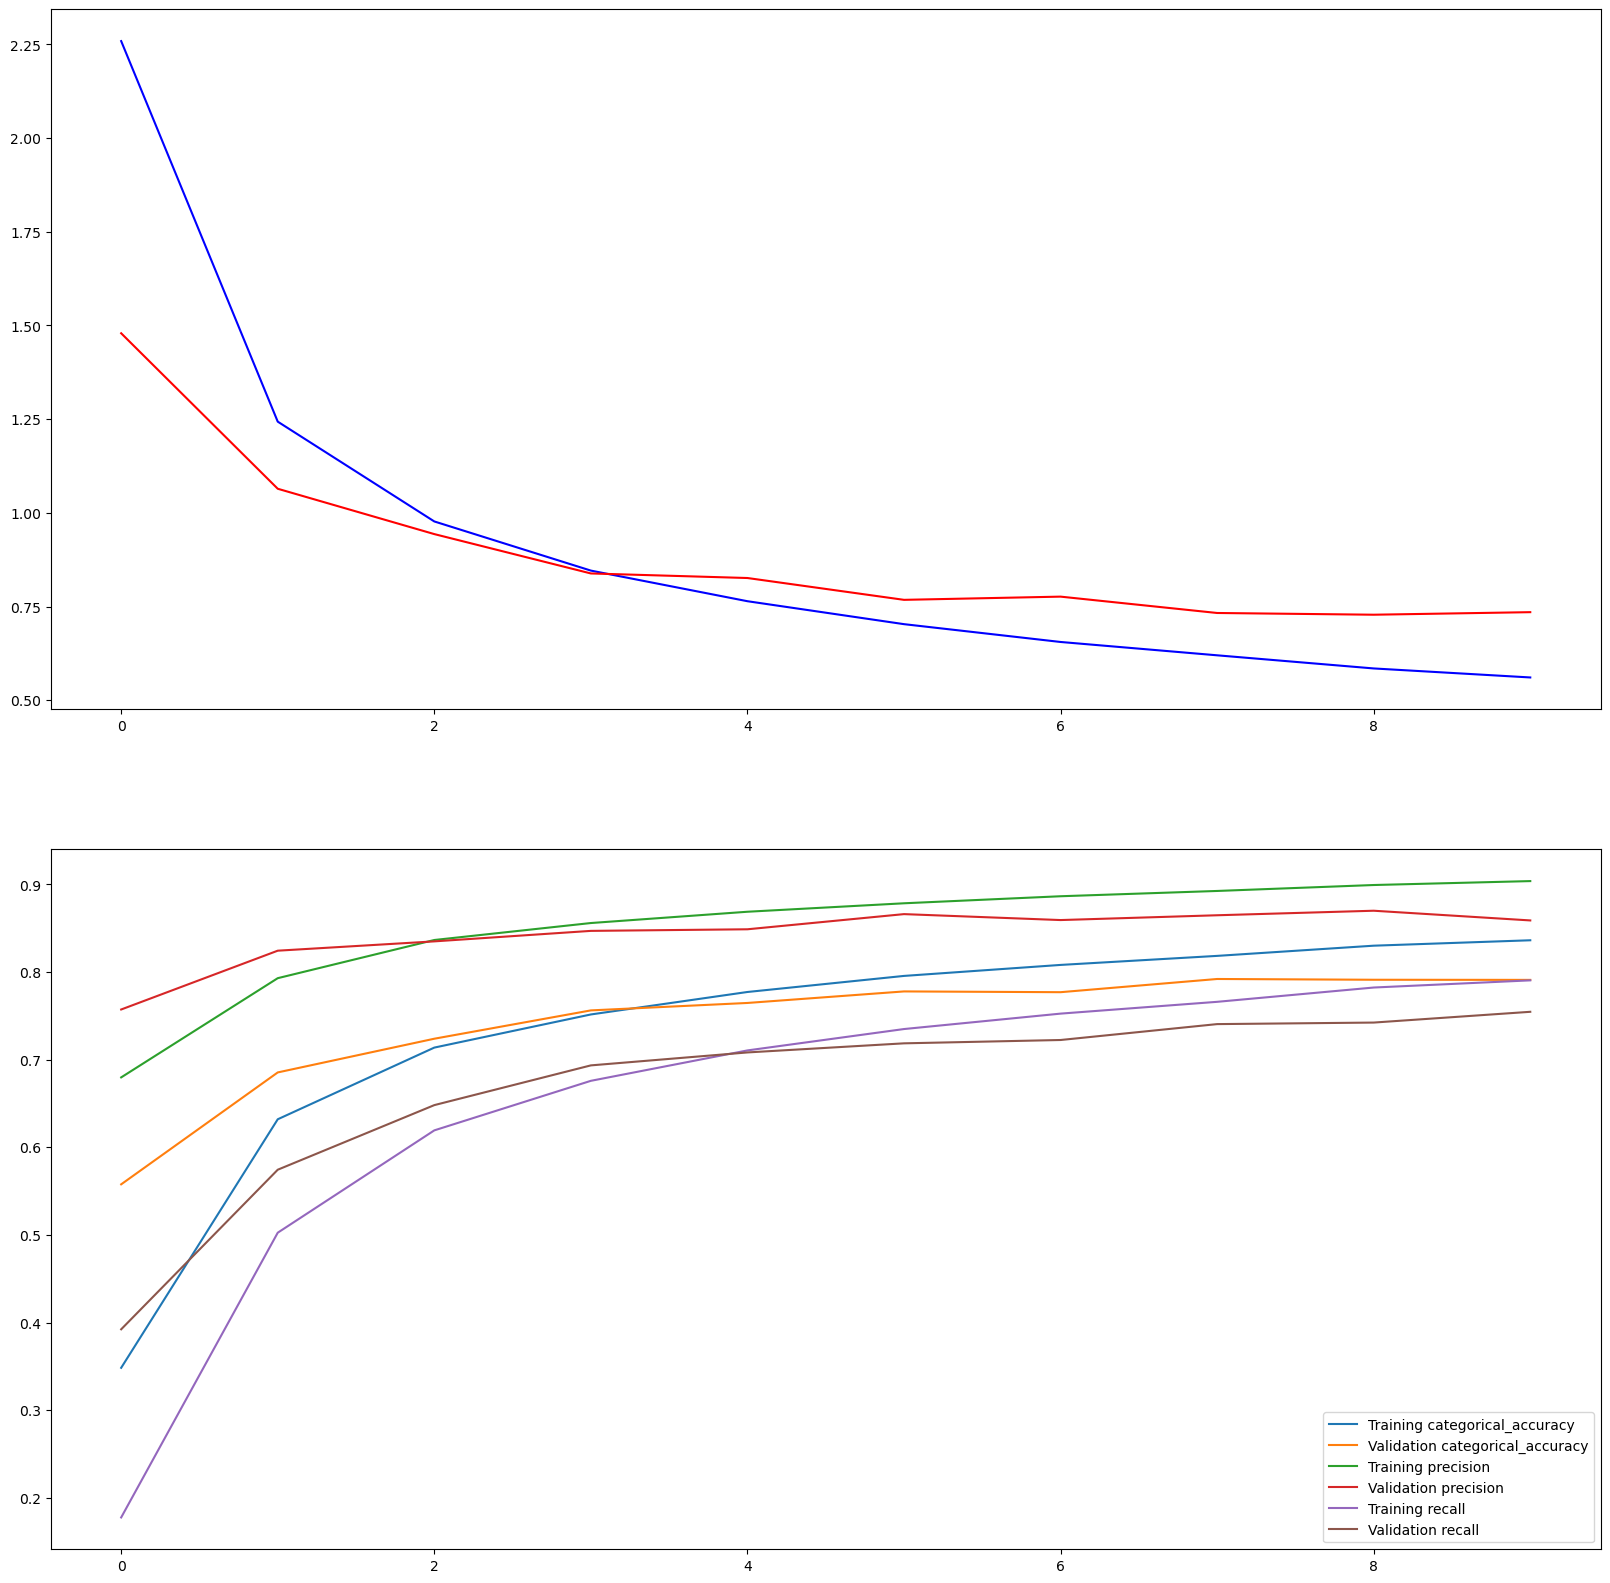

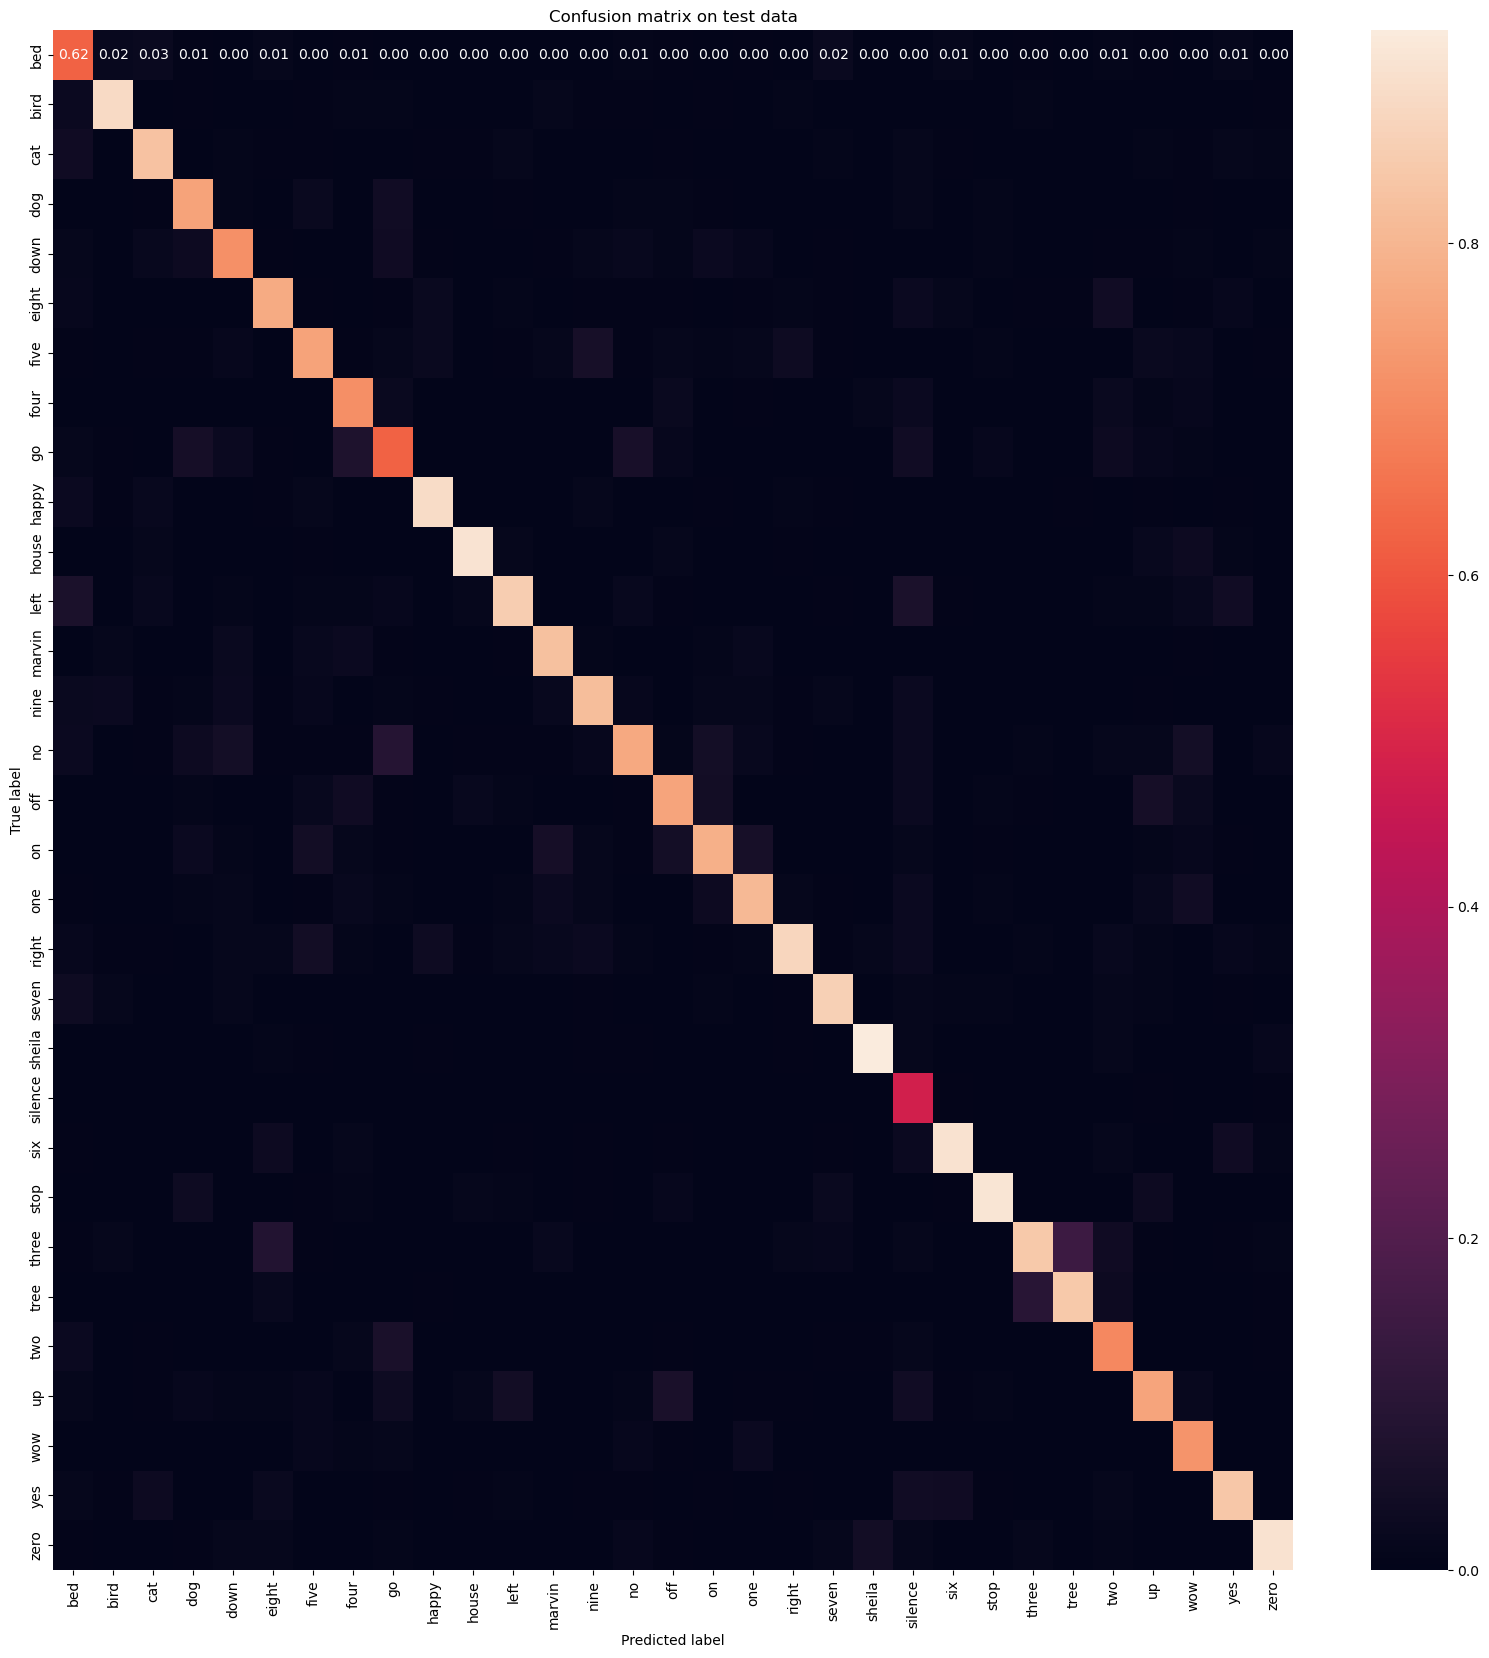

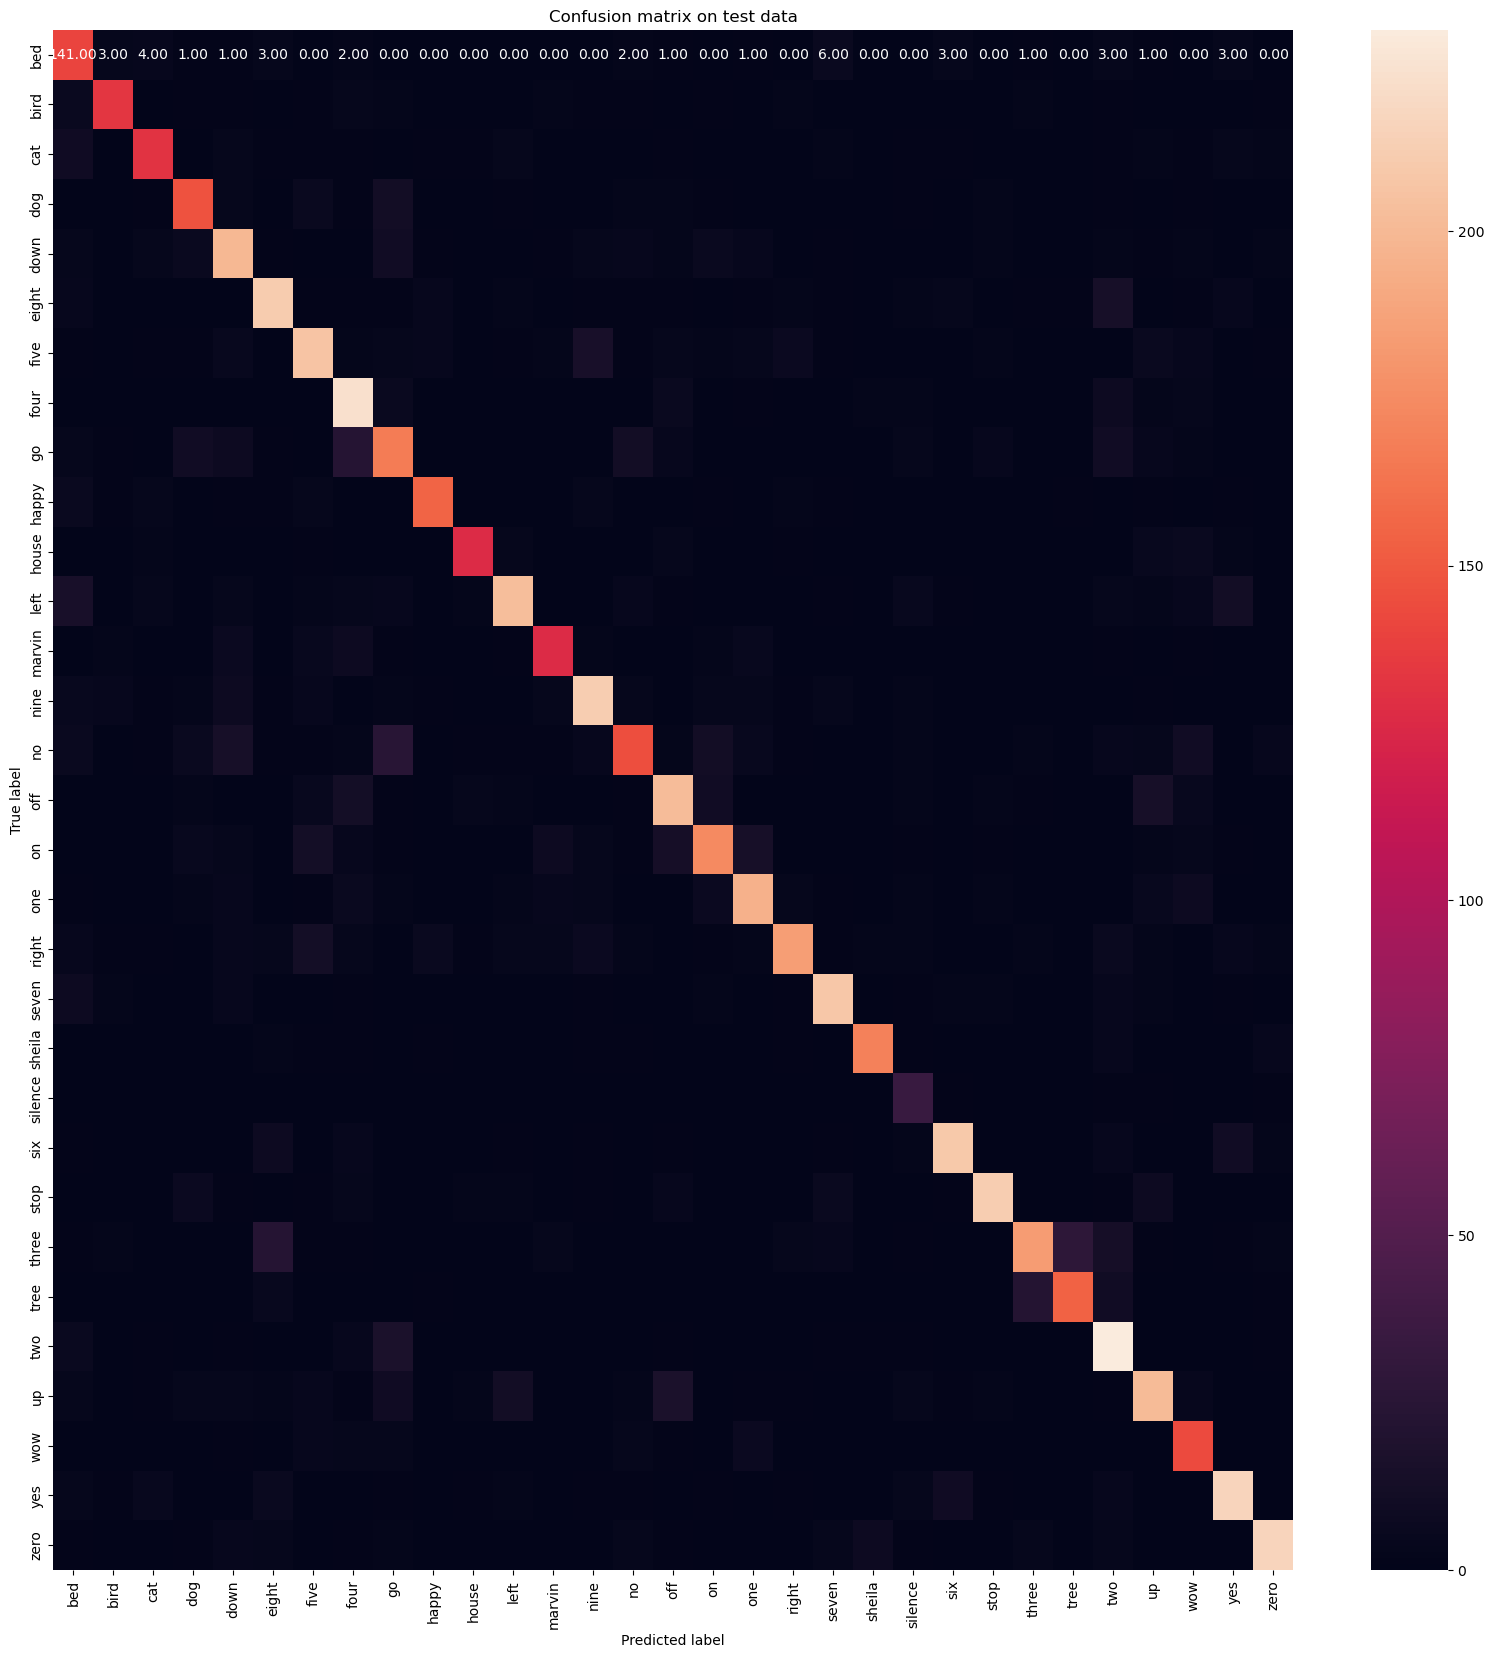

1609/1609 [==============================] - 199s 124ms/step
Accuracy score on train dataset: 0.8539991453987492
214/214 [==============================] - 27s 124ms/step
Accuracy score on validation dataset: 0.7909902003802838
Accuracy score on test dataset: 0.794442828047716


In [12]:
model = modelTransformer()
repeat_train(modelTransformer, (X_train, Y_train), (X_valid, Y_valid), (X_test, Y_test), lr=0.001, epochs=10, batch=64,
             seeds=[0], path='checkpoint_transformer')

## Committee

In [92]:
tf.random.set_seed(1337)

In [93]:
ind = np.where(CLASSES=='silence')[0]

categorical_labels = np.argmax(Y_train, axis=1)
Y_train_binary = np.where(categorical_labels == ind, 1, 0)

categorical_valid = np.argmax(Y_valid, axis=1)
Y_valid_binary = np.where(categorical_valid == ind, 1, 0)

In [94]:
def modelTransformerBinary():
    inputs = Input(shape=(99,13,))
    x_encoded = TransformerEncoder(num_attention_heads=13, num_layers=2, intermediate_size=128, dropout_rate=0.2, norm_first=True)(inputs)
    x_decoded = TransformerDecoder(num_attention_heads=13, num_layers=2, intermediate_size=128, dropout_rate=0.2, norm_first=True)(inputs, x_encoded)
    flatten = Flatten()(x_decoded)
    dropout = Dropout(0.2)(flatten)
    outputs = Dense(1, activation='softmax')(dropout)
    model = tf.keras.Model(inputs, outputs)
    return model

In [95]:
model_silence = modelTransformerBinary()
model_silence.compile(loss='binary_crossentropy', metrics=metrics, optimizer='adam')

In [96]:
history = model_silence.fit(x=X_train, y=Y_train_binary, batch_size=64, validation_data=(X_valid, Y_valid_binary), epochs=10)

Epoch 1/10
805/805 [==============================] - 440s 541ms/step - loss: 0.0431 - categorical_accuracy: 1.0000 - auc: 0.5000 - precision: 0.0077 - recall: 1.0000 - val_loss: 0.0145 - val_categorical_accuracy: 1.0000 - val_auc: 0.5000 - val_precision: 0.0057 - val_recall: 1.0000
Epoch 2/10
805/805 [==============================] - 445s 553ms/step - loss: 0.0208 - categorical_accuracy: 1.0000 - auc: 0.5000 - precision: 0.0077 - recall: 1.0000 - val_loss: 0.0110 - val_categorical_accuracy: 1.0000 - val_auc: 0.5000 - val_precision: 0.0057 - val_recall: 1.0000
Epoch 3/10
805/805 [==============================] - 439s 546ms/step - loss: 0.0157 - categorical_accuracy: 1.0000 - auc: 0.5000 - precision: 0.0077 - recall: 1.0000 - val_loss: 0.0086 - val_categorical_accuracy: 1.0000 - val_auc: 0.5000 - val_precision: 0.0057 - val_recall: 1.0000
Epoch 4/10
805/805 [==============================] - 434s 539ms/step - loss: 0.0127 - categorical_accuracy: 1.0000 - auc: 0.5000 - precision: 0.007

In [97]:
model_normal = modelTransformer()
model_normal.compile(loss='categorical_crossentropy', metrics=metrics, optimizer='adam')
history = model_normal.fit(x=X_train, y=Y_train, batch_size=64, validation_data=(X_valid, Y_valid), epochs=10)

Epoch 1/10
805/805 [==============================] - 468s 576ms/step - loss: 2.4081 - categorical_accuracy: 0.3158 - auc: 0.8621 - precision: 0.6601 - recall: 0.1429 - val_loss: 1.5633 - val_categorical_accuracy: 0.5426 - val_auc: 0.9437 - val_precision: 0.7451 - val_recall: 0.3642
Epoch 2/10
805/805 [==============================] - 404s 502ms/step - loss: 1.3983 - categorical_accuracy: 0.5850 - auc: 0.9548 - precision: 0.7733 - recall: 0.4310 - val_loss: 1.1761 - val_categorical_accuracy: 0.6582 - val_auc: 0.9638 - val_precision: 0.7988 - val_recall: 0.5435
Epoch 3/10
805/805 [==============================] - 404s 502ms/step - loss: 1.1179 - categorical_accuracy: 0.6678 - auc: 0.9688 - precision: 0.8137 - recall: 0.5550 - val_loss: 1.0376 - val_categorical_accuracy: 0.7031 - val_auc: 0.9696 - val_precision: 0.8113 - val_recall: 0.6251
Epoch 4/10
805/805 [==============================] - 407s 505ms/step - loss: 0.9878 - categorical_accuracy: 0.7100 - auc: 0.9742 - precision: 0.831

In [98]:
silence_preds = model_silence.predict(X_test)
all_preds = model_normal.predict(X_test)

215/215 [==============================] - 26s 121ms/step


In [99]:
combined_preds = np.zeros_like(all_preds)

for i, pred in enumerate(silence_preds):
    if pred == 1:
        combined_preds[i] = 0
        combined_preds[i, ind] = 1
    else:
        combined_preds[i] = all_preds[i]

In [100]:
accuracy = accuracy_score(Y_test, combined_preds)
precision = precision_score(Y_test, combined_preds, average='weighted')
recall = recall_score(Y_test, combined_preds, average='weighted')
f1 = f1_score(Y_test, combined_preds, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.005673552516729706
Precision: 3.218919816008998e-05
Recall: 0.005673552516729706
F1 Score: 6.401520270575975e-05


C:\Users\48695\anaconda3\envs\plswork\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


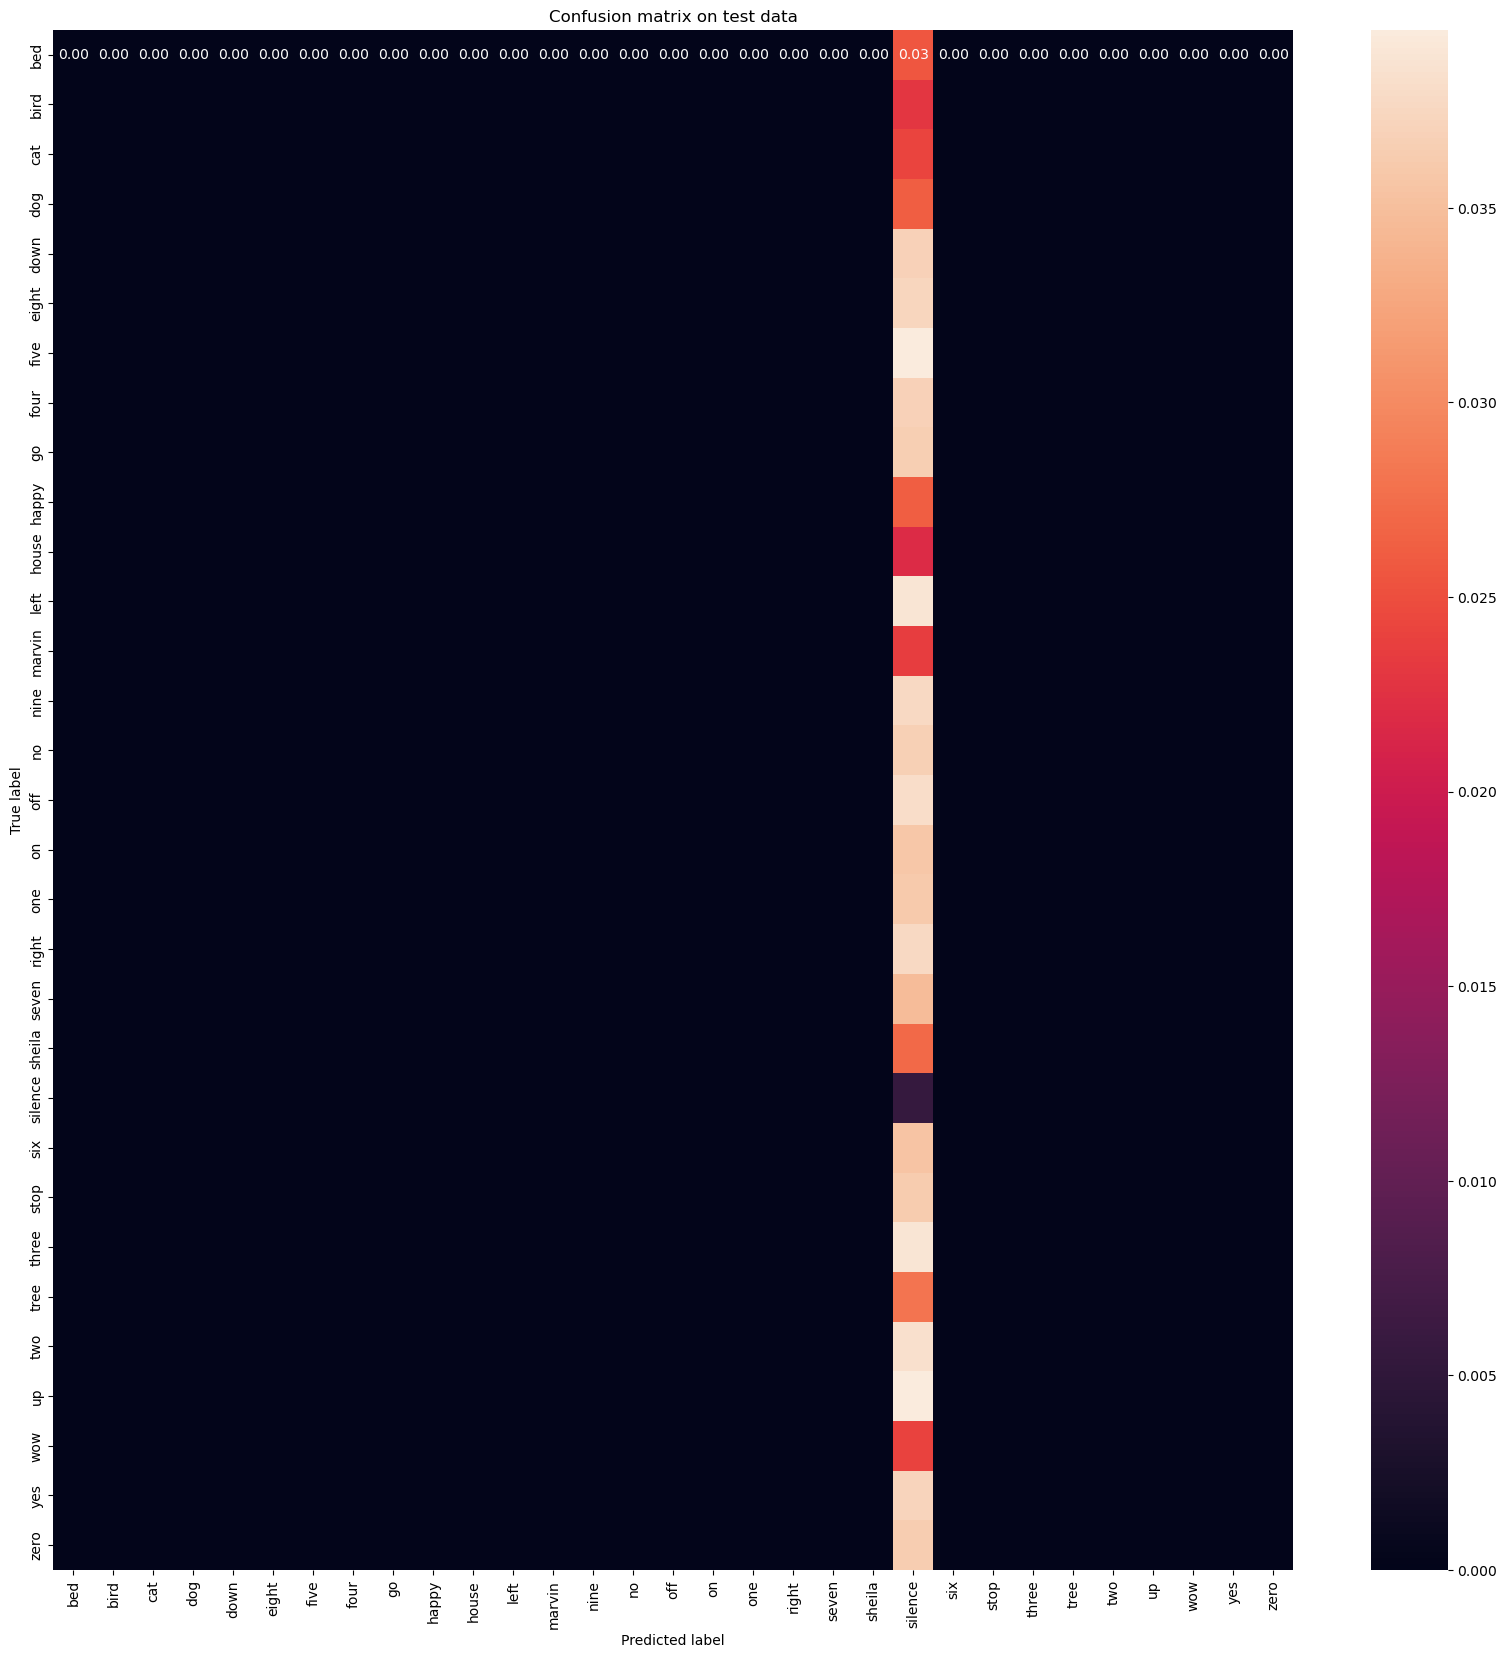

In [114]:
#true_labels = np.concatenate([y for y in Y_test], axis=0)
tf_labels = tf.argmax(Y_test, axis=1).numpy()
predicted_classes = np.argmax(combined_preds, axis=1)
#conf_matrix = tf.math.confusion_matrix(tf_labels, predicted_classes, num_classes=n_classes)

#disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix.numpy(), display_labels=CLASSES)
#fig, ax = plt.subplots(figsize=(11, 9)) 
#disp.plot(ax=ax) 
#plt.show()

result = confusion_matrix(tf_labels, predicted_classes , normalize='pred')
plt.figure(figsize=(20,20))
labels = CLASSES
sns.heatmap(result, annot=True, fmt='.2f', xticklabels=labels, yticklabels=labels)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion matrix on test data')
plt.show()